<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [22]:
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer

from sklearn import neighbors, tree
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool, CatBoost
import lightgbm as lgb

from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import probplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
import wordcloud
from wordcloud import WordCloud
from statsmodels.tsa.seasonal import seasonal_decompose

In [35]:
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates =[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates =[0])


data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [36]:
data = data.resample("1H").sum()

<AxesSubplot:xlabel='datetime'>

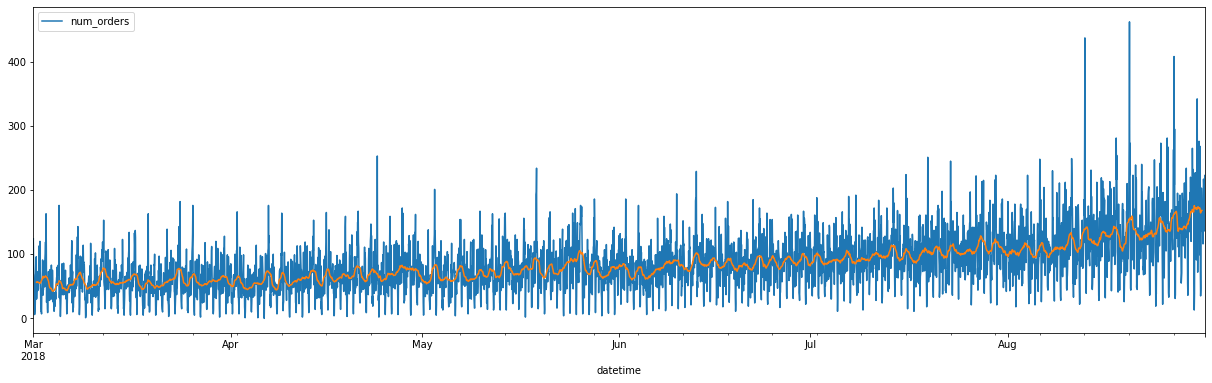

In [59]:
data.plot(figsize = (21,6))
decomposed = seasonal_decompose(data) 
decomposed.trend.plot()


In [61]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


<AxesSubplot:xlabel='datetime'>

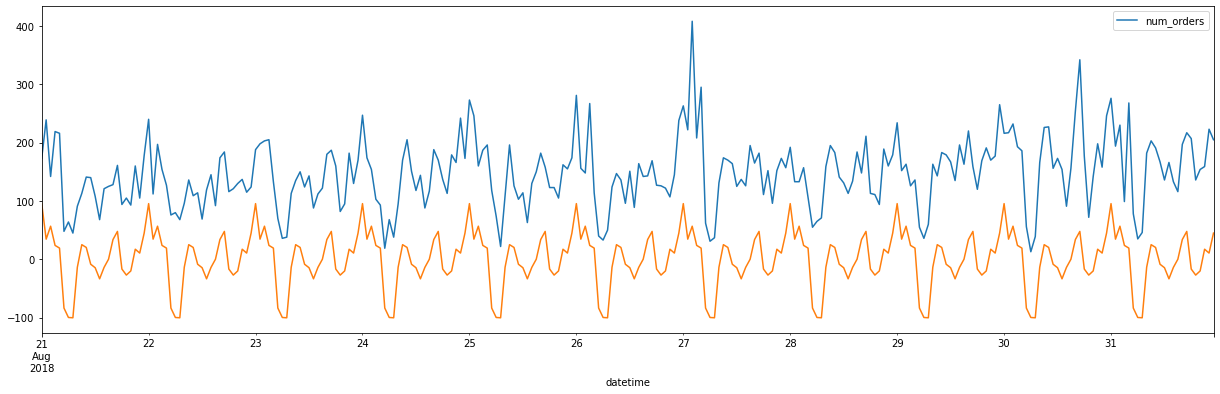

In [81]:
decomposed = seasonal_decompose(data['2018-08-21':'2018-08-31']) 
data['2018-08-21':'2018-08-31'].plot()
decomposed.seasonal.plot(figsize = (21,6))


<AxesSubplot:xlabel='datetime'>

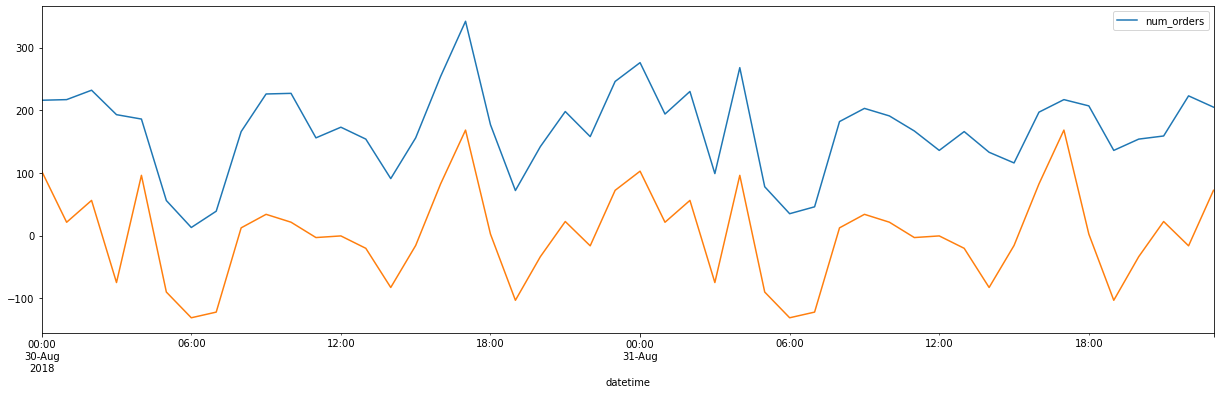

In [82]:
decomposed = seasonal_decompose(data['2018-08-30':'2018-08-31']) 
data['2018-08-30':'2018-08-31'].plot()
decomposed.seasonal.plot(figsize = (21,6))

<AxesSubplot:xlabel='datetime'>

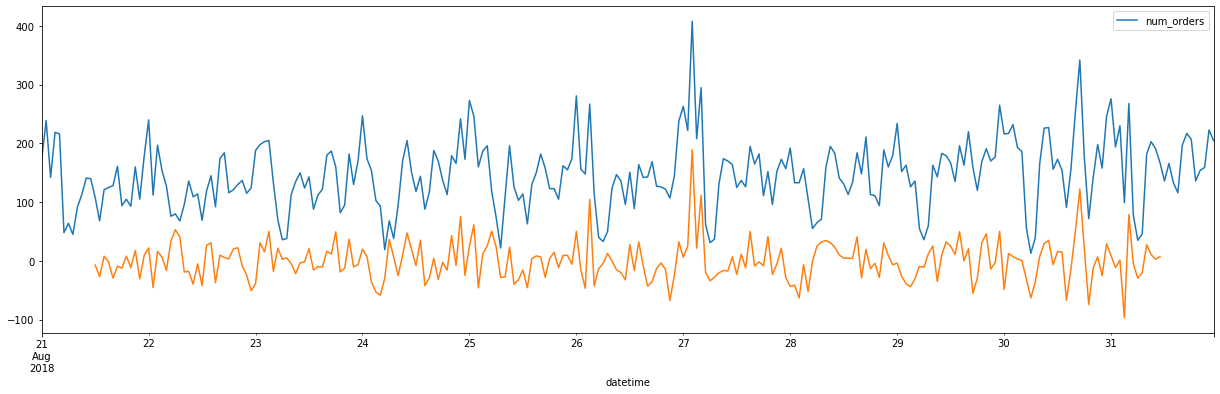

In [80]:
decomposed = seasonal_decompose(data['2018-08-21':'2018-08-31'])
data['2018-08-21':'2018-08-31'].plot()
decomposed.resid.plot(figsize = (21,6))

## Анализ

In [15]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [ ]:
# импортируем автокорреляционную функцию (ACF)
from statsmodels.graphics.tsaplots import plot_acf

# применим функцию к нашему набору данных
plot_acf(data, alpha = None)
plt.show()

In [ ]:
# применим ее к данным о пассажирах
plot_acf(passengers)
plt.show()

In [ ]:
# построим аналогичный график для данных о рождаемости
plot_acf(births)
plt.show()

## Обучение

In [ ]:
#### Модель SARIMAX

In [ ]:
# разобьём данные на обучающую и тестовую выборки

# обучающая выборка будет включать данные до декабря 1959 года включительно
train = passengers[:'1959-12']

# тестовая выборка начнется с января 1960 года (по сути, один год)
test = passengers['1960-01':]

In [ ]:
# выведем эти данные на графике
plt.plot(train, color = "black")
plt.plot(test, color = "red")

# заголовок и подписи к осям
plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

In [ ]:
# принудительно отключим предупреждения системы
import warnings
warnings.simplefilter(action = 'ignore', category = Warning)

# обучим модель с соответствующими параметрами, SARIMAX(3, 0, 0)x(0, 1, 0, 12)

# импортируем класс модели
from statsmodels.tsa.statespace.sarimax import SARIMAX

# создадим объект этой модели
model = SARIMAX(train, 
                order = (3, 0, 0), 
                seasonal_order = (0, 1, 0, 12))

# применим метод fit
result = model.fit()

In [ ]:
print(result.summary())

In [ ]:
# тестовый прогнозный период начнется с конца обучающего периода
start = len(train)

# и закончится в конце тестового
end = len(train) + len(test) - 1
  
# применим метод predict
predictions = result.predict(start, end)
predictions

In [ ]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.plot(train, color = 'black')
plt.plot(test, color = 'red')
plt.plot(predictions, color = 'green')

# заголовок и подписи к осям
plt.title('Обучающая выборка, тестовая выборка и тестовый прогноз')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

In [ ]:
# импортируем метрику
from sklearn.metrics import mean_squared_error

# рассчитаем MSE
print(mean_squared_error(test, predictions))

# и RMSE
print(np.sqrt(mean_squared_error(test, predictions)))

In [ ]:
# прогнозный период начнется с конца имеющихся данных
start = len(passengers)

# и закончится 36 месяцев спустя
end = (len(passengers) - 1) + 3 * 12

# теперь построим прогноз на три года вперед
forecast = result.predict(start, end)

# посмотрим на весь 1963 год
forecast[-12:]

In [ ]:
# выведем две кривые (фактические данные и прогноз на будущее)
plt.plot(passengers, color = 'black')
plt.plot(forecast, color = 'blue')

# заголовок и подписи к осям
plt.title('Фактические данные и прогноз на будущее')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

In [ ]:
# установим pmdarima
# !pip install pmdarima

In [ ]:
# !pip install statsmodels

In [ ]:
# импортируем функцию для автоматического подбора параметров модели ARIMA
from pmdarima import auto_arima

  
# "погасим" предупреждения
import warnings
warnings.filterwarnings("ignore")
  
# настроим поиск параметров на обучающей выборке
parameter_search = auto_arima(train, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 0, seasonal = True,
                         d = None, D = 1, trace = True, error_action ='ignore', suppress_warnings = True,  stepwise = True)           #
  
# выведем результат
print(parameter_search.summary())

## Тестирование

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48